# **0. Configuraciones**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title **A. INFORMACIÓN DE GPU**
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Jun  3 14:46:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title **B. INSTALANDO DEPENDENCIAS**
#@markdown  **B.1 Instalando Pytorch Lighthing**
!pip install pytorch-lightning
#@markdown  **B.2 Instalando Mediapipe**
!pip install mediapipe
#@markdown **B.3 Instalando TIMM from github**
!pip install git+https://github.com/rwightman/pytorch-image-models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 9.5 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 
     |████████████████████████████████| 419 kB 75.0 MB/s 
     |████████████████████████████████| 140 kB 93.5 MB/s 
     |████████████████████████████████| 1.1 MB 71.2 MB/s 
     |████████████████████████████████| 271 kB 78.6 MB/s 
     |████████████████████████████████| 94 kB 4.9 MB/s 
     |████████████████████████████████| 144 kB 78.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwight

In [ ]:
#@title **C. IMPORTANDO LIBRERIAS**
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchvision.models as models
#import torchmetrics
#from pytorch_lightning.metrics.functional import accuracy
from torchmetrics.classification import Accuracy
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from datetime import datetime
import sys, os
from glob import glob
import imageio
from torch.utils.data import Dataset, DataLoader
import timm
import shutil
from tqdm.notebook  import tqdm
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn import metrics as sk_metrics
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report

In [ ]:
timm.list_models()

# **1. Carga del Dataset**




In [ ]:
#@title **funciones** { run: "auto" }
import shutil
from tqdm.notebook  import tqdm
import random
import os
import zipfile
random.seed(10)

#root_zip_dataset = '/content/gdrive/MyDrive/Colab Notebooks/dataset/RWF2000Processed/frames-150.7z'
#!cp "{root_zip_dataset}" .
#!p7zip -d frames-150.7z

def copy_data(data_path, data_type, n_samples, opt=0, all=0):
  TRAIN_PATH = os.path.join(data_path, data_type)
  list_dire_clases= [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]
  list_name_clases = [os.path.basename(x) for x in list_dire_clases]

  for class_path, class_name in zip(list_dire_clases, list_name_clases):
    if(opt == 1 and class_name=="Contempt"):
      continue

    files_annot = glob(os.path.join(class_path, "*.jpg"))

    if all:
      samples = files_annot
    else:
      samples = random.sample(files_annot, n_samples)
    print(f"Copiando de {TRAIN_PATH}")
    print(f"Clase {class_name} tiene {len(samples)} registros seleccionados")
    #continue
    data_new_dir = os.path.join("/content/data", data_type, class_name)
    if not os.path.exists(data_new_dir):
      os.makedirs(data_new_dir)
    
    print("copiando, por favor espere!!!...")
    pbar = tqdm(total=len(samples))
    for sample in samples:
      pbar.update(1)
      new_dir = os.path.join(data_new_dir, os.path.basename(sample))
      shutil.copy(sample, new_dir)
    pbar.close()

def copy_data(root_data, dataset_name, clases = 7):
  root_path = os.path.join(root_data,dataset_name)
  save_path_class ="data"
  if not os.path.exists(save_path_class):
      os.makedirs(save_path_class)
  
  with zipfile.ZipFile(root_path, 'r') as zip_ref:
    if clases == 7:
      listOfFileNames = zip_ref.namelist()
      for file_n in zip_ref.namelist():
        if file_n.startswith('train/Contempt/') or file_n.startswith('val/Contempt/'):
          continue
        else:
          zip_ref.extract(file_n, save_path_class)
    else:
      zip_ref.extractall(save_path_class)

In [ ]:
%%time
root_data = "/content/drive/MyDrive/Datasets/dataset UCSP"
data_name = "Affect_net_local_seg_alig.zip"
copy_data(root_data, data_name)

CPU times: user 29.8 s, sys: 9.92 s, total: 39.7 s
Wall time: 42.7 s


In [ ]:
DATA_PATH = "/content/data/"

In [ ]:
TRAIN_PATH = os.path.join("/content/data/train")
list_dire_clases= [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]
list_name_clases = [os.path.basename(x) for x in list_dire_clases]
cantidades = []
for class_path, class_name in zip(list_dire_clases, list_name_clases):
  files_annot = glob(os.path.join(class_path, "*.jpg"))
  print(f"Clase {class_name} tiene {len(files_annot)} registros")

Clase Contempt tiene 22500 registros
Clase Surprise tiene 28180 registros
Clase Disgust tiene 22818 registros
Clase Sadness tiene 23000 registros
Clase Neutral tiene 23000 registros
Clase Happiness tiene 23000 registros
Clase Anger tiene 23000 registros
Clase Fear tiene 25512 registros


# **2. VISUALIZANDO EL DATASET**


Clase Surprise tiene 28180 registros
Clase Disgust tiene 22818 registros
Clase Sadness tiene 23000 registros
Clase Neutral tiene 23000 registros
Clase Happiness tiene 23000 registros
Clase Anger tiene 23000 registros
Clase Fear tiene 25512 registros


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

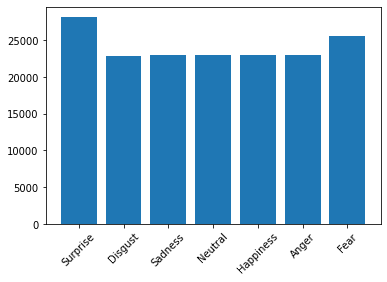

In [ ]:
#@title DATOS DE ENTRENAMIENTO
# Datos de entrenamiento
DATA_PATH="/content/data"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
list_dire_clases= [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]
list_name_clases = [os.path.basename(x) for x in list_dire_clases]
cantidades = []
limit = 4200
print()
for class_path, class_name in zip(list_dire_clases, list_name_clases):
  files_annot = glob(os.path.join(class_path, "*.jpg"))
  files_names = [os.path.basename(x) for x in files_annot]
  print(f"Clase {class_name} tiene {len(files_annot)} registros")
  tama = len(files_annot)
  cantidades.append(len(files_annot))
  #ajustar_affecnetdata(files_annot, files_names, class_name, limit)
plt.bar(list_name_clases,cantidades)
plt.xticks(rotation=45)



Clase Surprise tiene 500 registros
Clase Disgust tiene 500 registros
Clase Sadness tiene 500 registros
Clase Neutral tiene 500 registros
Clase Happiness tiene 500 registros
Clase Anger tiene 500 registros
Clase Fear tiene 500 registros


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

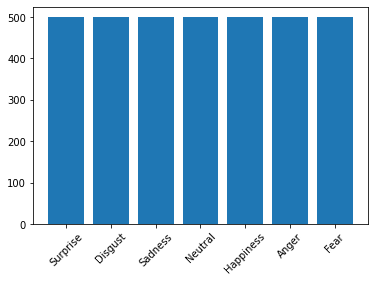

In [ ]:
#@title DATOS DE VALIDACION
# Datos de entrenamiento
TRAIN_PATH = os.path.join(DATA_PATH, "valid")
list_dire_clases= [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]
list_name_clases = [os.path.basename(x) for x in list_dire_clases]
cantidades = []
limit = 4200
for class_path, class_name in zip(list_dire_clases, list_name_clases):
  files_annot = glob(os.path.join(class_path, "*"))
  files_names = [os.path.basename(x) for x in files_annot]
  print(f"Clase {class_name} tiene {len(files_annot)} registros")
  tama = len(files_annot)
  cantidades.append(len(files_annot))
  #ajustar_affecnetdata(files_annot, files_names, class_name, limit)
plt.bar(list_name_clases,cantidades)
plt.xticks(rotation=45)

#**3. Dataset definition**

In [ ]:
# https://discuss.pytorch.org/t/why-do-we-need-subsets-at-all/49391/7
# adapted from ptrblck post
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]      


        #plt.imshow(x)    
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

### directory structure of the dataset
```
root
|
-- train
|
-- validation
```



In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, dat_norm, data_dir: str, img_size = 224, batch_size = 200, align=True):
        super().__init__()
        self.data_dir = data_dir
        self.img_size = img_size
        self.align = align
        self.transform = transforms.Compose([
            transforms.Resize(size = self.img_size),
            #transforms.CenterCrop(size = self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(dat_norm[0], dat_norm[1])
        ])

        self.train_transform = transforms.Compose([
            transforms.Resize(size = self.img_size),
            #transforms.RandomRotation(degrees=15),
            #transforms.CenterCrop(size=self.img_size),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(dat_norm[0], dat_norm[1])
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.batch_size = batch_size
        self.num_workers = 4
    
    def setup(self, stage = None):
        # train path
        path_train = os.path.join(self.data_dir, 'train')
        # test path
        path_test =  os.path.join(self.data_dir, 'valid')
        mydataset_train = datasets.ImageFolder(root = path_train)
        mydataset_test  = datasets.ImageFolder(root = path_test)
        self.path_test = path_test
        self.categories =  mydataset_test.class_to_idx
        traindataset = MyLazyDataset(mydataset_train, self.train_transform, rotate = self.align) # train
        validdataset = MyLazyDataset(mydataset_train, self.train_transform, rotate = self.align) # validation
        self.testdataset = MyLazyDataset(mydataset_test, self.transform, rotate = self.align) # test

        # Create the index splits for training and validation  
        # Train is divided into two subsets: train and validation
        train_size = 0.9
        num_train = len(mydataset_train)
        indices = list(range(num_train))
        split = int(np.floor(train_size * num_train))
        np.random.shuffle(indices)
        train_idx, valid_idx = indices[:split], indices[split:]
        self.traindata = torch.utils.data.Subset(traindataset, indices=train_idx)
        self.validdata = torch.utils.data.Subset(validdataset, indices=valid_idx)

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.traindata, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers, 
            drop_last=True)
        return train_loader
    def val_dataloader(self):
        valid_loader = torch.utils.data.DataLoader(
            self.validdata, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers, 
            drop_last=True)
        return valid_loader
    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(
            self.testdataset, 
            batch_size=self.batch_size,
            num_workers=self.num_workers, 
            drop_last=True)
        return test_loader

In [ ]:
class NetworkTransferLearning(pl.LightningModule):
    def __init__(self, type_net, optimizer="Adam", num_classes = 7, lr = 1e-3, pretrained = True):
        super().__init__()
        self.num_classes = num_classes
        self.optimizer = optimizer
        self.lr = lr
        self.backbone = timm.create_model(type_net, pretrained = pretrained)
        if pretrained:
            # freeze  weights
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.num_in_feat = self.backbone.get_classifier().in_features

        block = nn.Sequential(nn.Linear(self.num_in_feat, 1024), 
                              nn.Dropout(0.5), 
                              nn.Linear(1024, 512), 
                              #nn.Dropout(0.5), 
                              nn.Linear(512, self.num_classes))

        name, module = list(self.backbone.named_children())[-1]
        self.backbone._modules[name] = block        

        # 3 Loss function
        self.loss = nn.CrossEntropyLoss()

        # 4 Metrics
        self.train_acc = Accuracy()
        self.valid_acc = Accuracy(compute_on_step=False)  
        self.test_acc  = Accuracy(compute_on_step=False)       

    def forward(self, x):
        out = self.backbone.forward(x)
        #out = self.backbone(x)
        return out

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        
        loss = self.loss(outputs, targets)

        #preds = nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        self.train_acc(preds, targets)

        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc)
        return loss

    def training_epoch_end(self, outs):
        loss =self.train_acc.compute()        
        self.log('avg_train_acc',loss)
        print(f"avg_train_acc: {loss}, ", end=" ")
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        #preds = nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        self.valid_acc(preds, targets)
        self.log('val_loss', loss)
        self.log('val_acc', self.valid_acc)
        return loss
    
    def validation_epoch_end(self, val_step_outputs):
        avg_val_acc = self.valid_acc.compute()
        self.log('avg_val_acc',avg_val_acc)
        print(f"avg_val_acc: {avg_val_acc}")

    def test_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        #preds = nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        #print(preds)
        self.test_acc(preds, targets)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        return loss
    
    def test_epoch_end(self, val_step_outputs):
        self.log('avg_test_acc', self.test_acc.compute())

    def configure_optimizers(self):
      if self.optimizer == "Adam":
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
      else:
        #torch.optim.Adam(self.parameters(), lr=self.lr)
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
      return optimizer

    def get_mean_std(self):
      return self.backbone.default_cfg["mean"], self.backbone.default_cfg["std"]

    def set_lr_optimizer(self, lr, optimizer):
        self.optimizer = optimizer
        self.lr = lr
     



In [ ]:
from torch import optim
def train_process():
  from pytorch_lightning import callbacks as pl_callbacks
  from sklearn import metrics as sk_metrics
  callback_model_checkpoint = pl_callbacks.ModelCheckpoint(
      '{epoch}-{valid_loss:.3f}', 
      monitor='val_loss', 
      mode='min'
  )

  chk_dir = "Codigos"
  img_size = 224
  base_dir = "/content/data"#/content/drive/MyDrive/UNIVERSIDAD CATÓLICA PROYECTOS/EMOTION RECOGNITION/Datasets/Affect_net_local_gray"
  num_class = 7
  batch_size=150 #32
  
  model = 'swin_large_patch4_window7_224_in22k'

  optimizer = "Adam"
  lr = 1e-6
  modelo = NetworkTransferLearning(type_net = model, optimizer = optimizer, num_classes=num_class, lr=lr)
  dm = DataModule(modelo.get_mean_std(),data_dir = base_dir, img_size = img_size, batch_size=batch_size, align = True)
  trainer = Trainer(fast_dev_run=False, default_root_dir=chk_dir, gpus=1, progress_bar_refresh_rate=20, max_epochs=10, checkpoint_callback=callback_model_checkpoint)
  n = len(list(modelo.parameters()))
  for i, param in enumerate(modelo.parameters()):
    if i>n*0.70:
      param.requires_grad = True
  trainer.fit(modelo, dm)
  trainer.test(modelo, datamodule=dm)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_process()

# **ETAPA DE PRUEBAS**

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "Codigos/lightning_logs"

In [ ]:
#@title func
@torch.no_grad()
def get_all_preds(model, loader):
    #device = "cpu"

    all_preds = torch.tensor([]).to("cuda:0")
    all_labels = torch.tensor([]).to("cuda:0")
    for i, (x, y) in enumerate(loader):
        print(f"Cargando batch {i+1}")
        x, y = x.to(device), y.to(device)
        preds = model(x)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat(
            (all_labels, y)
            ,dim=0
        )
    return all_preds, all_labels

In [ ]:
model_t = 'swin_large_patch4_window7_224_in22k'
modelo2 = NetworkTransferLearning.load_from_checkpoint("Codigos/lightning_logs/version_63/checkpoints/epoch=32-step=9702.ckpt", type_net=model_t, num_classes = 7)


In [ ]:
#base_dir = DATA_PATH "/content/drive/MyDrive/UNIVERSIDAD CATÓLICA PROYECTOS/EMOTION RECOGNITION/Datasets/DATA_PATH"
#test_path = "/content/drive/MyDrive/UNIVERSIDAD CATÓLICA PROYECTOS/EMOTION RECOGNITION/Datasets/DATA_PATH"
img_size = 224
dm = DataModule(modelo2.get_mean_std(), data_dir = "/content/data", img_size = img_size, batch_size=1)
dm.setup()

In [ ]:
y_true, y_pred = [],[]
#modelo.freeze()
#modelo.eval()
#loader = dm.test_dataloader()
#for i, (x, y) in enumerate(loader):
#    print(f"Cargando batch {i+1}")
#    #y_pred.extend([x.shape[0]])
#    y_true.extend(list(y))
#    #y_hat = modelo(x)#modelo.forward(x).argmax(axis=1).cpu().detach().numpy()
#    pred_probs =  modelo(x)
#    y_pred.extend(pred_probs.argmax(axis=-1).cpu().numpy())
#    #y_true.append(y)
from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelo2 = modelo2.to(device)
loader = dm.test_dataloader()

with torch.no_grad():
    test_preds, all_labels = get_all_preds(modelo2, loader)

y_true = all_labels.cpu()
y_pred =test_preds.argmax(dim=1).cpu()
cm = confusion_matrix(y_true, y_pred)
tot = np.sum(cm, axis=1)
cm_porc = np.divide(cm, np.reshape(tot, (-1,1)))
#print(cm_porc)



In [ ]:
print(f'Accuracy score on test data:\t{sk_metrics.accuracy_score(y_true, y_pred)}')
print(f'Macro F1 score on test data:\t{sk_metrics.f1_score(y_true, y_pred, average="macro")}')

In [ ]:
#@title Matriz de confusión en porcentajes
labels = list(dm.categories)
# Calculate confusion matrix
#confusion_matrix = sk_metrics.confusion_matrix(y_true, y_pred)
df_confusion_matrix = pd.DataFrame(cm_porc, index=labels, columns=labels)

# Show confusion matrix
plt.figure(figsize=(12, 12))
sn.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap='Oranges', linewidths=1, linecolor='black', fmt=".2%")
plt.xlabel('Predicted labels', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('True labels', fontsize=15)
plt.yticks(fontsize=12);
#plt.savefig(os.path.join(RESULTS_PATH, "confusion_matrix_porc.png"))

In [ ]:
#@title Matriz de confusión con cantidades
labels = list(dm.categories)
# Calculate confusion matrix
#confusion_matrix = sk_metrics.confusion_matrix(y_true, y_pred)
df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

# Show confusion matrix
plt.figure(figsize=(12, 12))
sn.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap='Oranges', linewidths=1, linecolor='black', fmt='g')
plt.xlabel('Predicted labels', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('True labels', fontsize=15)
plt.yticks(fontsize=12);
#plt.savefig(os.path.join(RESULTS_PATH, "confusion_matrix.png"))

In [ ]:
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
print(classification_report(y_true, y_pred, target_names=labels))

# Probar **nuevamente**

In [ ]:
model_t = 'swin_large_patch4_window7_224_in22k'
optimizer = "Adam"
lr = 1e-6
modelo2 = NetworkTransferLearning.load_from_checkpoint("/content/drive/MyDrive/Universidad UCSP/Proyecto Concytec/Codigos/lightning_logs/version_66/checkpoints/epoch=56-step=16758.ckpt", type_net=model_t, optimizer = optimizer, num_classes=7, lr=lr)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22k.pth


In [ ]:
from pytorch_lightning import callbacks as pl_callbacks
from sklearn import metrics as sk_metrics
callback_model_checkpoint = pl_callbacks.ModelCheckpoint(
      '{epoch}-{valid_loss:.3f}', 
      monitor='val_loss', 
      mode='min'
  )

chk_dir = "/content/drive/MyDrive/Universidad UCSP/Proyecto Concytec/Codigos"
img_size = 224
base_dir = "/content/data"#/content/drive/MyDrive/UNIVERSIDAD CATÓLICA PROYECTOS/EMOTION RECOGNITION/Datasets/Affect_net_local_gray"
num_class = 7
dm = DataModule(modelo2.get_mean_std(),data_dir = base_dir, img_size = img_size, batch_size=100, align = True)
n = len(list(modelo2.parameters()))
for i, param in enumerate(modelo2.parameters()):
  if i>n*0.70:
    param.requires_grad = True
trainer = Trainer(fast_dev_run=False, default_root_dir=chk_dir, gpus=1, progress_bar_refresh_rate=20, max_epochs=40, checkpoint_callback=callback_model_checkpoint)
trainer.fit(modelo2, dm)
trainer.test(modelo2, datamodule=dm)